In [3]:
import torch

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available! Using GPU.")
else:
    print("CUDA is not available. Using CPU.")


CUDA is not available. Using CPU.


In [5]:
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 
  
# data (as pandas dataframes) 
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features 
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets.copy() 
  
# metadata 
print(estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.metadata) 
  
# variable information 
print(estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.variables) 


{'uci_id': 544, 'name': 'Estimation of Obesity Levels Based On Eating Habits and Physical Condition ', 'repository_url': 'https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition', 'data_url': 'https://archive.ics.uci.edu/static/public/544/data.csv', 'abstract': 'This dataset include data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. ', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 2111, 'num_features': 16, 'feature_types': ['Integer'], 'demographics': ['Gender', 'Age'], 'target_col': ['NObeyesdad'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Tue Sep 10 2024', 'dataset_doi': '10.24432/C5H31Z', 'creators': [], 'intro_paper': {'ID': 358, 'type': 

In [6]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn

from pyro.infer import MCMC, NUTS
from pyro.infer import Predictive

/Users/patrickgunn/Documents/Documents - iCloud Drive/Uni Fourth Year/Full Year/Group Project/Bayesian-Neural-Network-Project/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC','CALC','MTRANS']
# One-hot encode categorical features, dropping the first category
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)
X_encoded = X_encoded.astype({col: int for col in X_encoded.select_dtypes('bool').columns})

# Convert X_encoded to a PyTorch tensor
X_tensor = torch.tensor(X_encoded.values, dtype=torch.float32)


In [8]:
y['NObeyesdad'] = y['NObeyesdad'].astype('category').cat.codes

# Convert to tensor
y_tensor = torch.tensor(y['NObeyesdad'].to_numpy(), dtype=torch.long)

In [9]:
x_tr, x_te, y_tr, y_te = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)

In [10]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=2, prior_scale=5.):
        super().__init__()
        self.in_dim = in_dim

        self.activation = nn.ReLU()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, self.in_dim)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        x = self.layers[-1](x).squeeze()  # hidden --> output
        x = torch.softmax(x, dim=1) # softmax activation
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(x), obs=y)
        return x

In [20]:
# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
model = BNN(in_dim = x_tr.shape[1], out_dim = 7, hid_dim=10, n_hid_layers=2, prior_scale=1)
#in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.

nuts_kernel = NUTS(model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# define model and data

# define MCMC sampler
nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(nuts_kernel, num_samples=250, warmup_steps=500)
mcmc.run(x_tr, y_tr)


Sample: 100%|██████████| 750/750 [14:45,  1.18s/it, step size=1.02e-03, acc. prob=0.929]


In [11]:
post_samples = mcmc.get_samples()

keys = list(post_samples.keys())
print(keys)

post_samples[keys[1]].shape

NameError: name 'mcmc' is not defined

In [49]:
model.forward(x_te)[1,]

tensor([1.3268e-09, 2.7714e-18, 4.0400e-35, 6.0849e-14, 1.0000e+00, 7.8739e-11,
        4.4545e-06])

In [22]:
# import pickle

# # Save dictionary to a pickle file
# with open('post_samples.pkl', 'wb') as f:
#     pickle.dump(post_samples, f)

In [12]:
# Load dictionary from the pickle file
import pickle
with open('post_samples.pkl', 'rb') as f:
    loaded_samples = pickle.load(f)

In [13]:
y_te = y_te.float()

In [14]:
predictive = Predictive(model=model, posterior_samples=loaded_samples)
preds = predictive(x_te)['obs']

mse = nn.MSELoss()
mse(preds, y_te)

preds[0,:]

NameError: name 'model' is not defined

In [27]:
relative_frequencies = torch.zeros(7, 634)
for j in range(preds.shape[1]):
    # Count the occurrences of each label in column j
    label_counts = torch.bincount(preds[:, j], minlength=7)
    # Calculate the relative frequency by dividing by the total number of predictions (50)
    relative_frequencies[:, j] = label_counts.float() / preds.shape[0]

relative_frequencies

tensor([[0.9480, 0.0000, 0.8240,  ..., 0.0000, 0.0000, 0.0000],
        [0.0520, 0.0000, 0.1720,  ..., 0.1240, 0.9240, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0200],
        ...,
        [0.0000, 0.9920, 0.0000,  ..., 0.0000, 0.0000, 0.0320],
        [0.0000, 0.0000, 0.0040,  ..., 0.8760, 0.0760, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [65]:
X_encoded.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.0,1.62,64.0,2.0,3.0,2.0,0.0,1.0,0,1,...,0,0,0,0,0,1,0,0,1,0
1,21.0,1.52,56.0,3.0,3.0,3.0,3.0,0.0,0,1,...,0,1,1,0,1,0,0,0,1,0
2,23.0,1.80,77.0,2.0,3.0,2.0,2.0,1.0,1,1,...,0,0,0,1,0,0,0,0,1,0
3,27.0,1.80,87.0,3.0,3.0,2.0,2.0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,1
4,22.0,1.78,89.8,2.0,1.0,2.0,0.0,0.0,1,0,...,0,0,0,0,1,0,0,0,1,0


dict_keys(['layers.0.bias', 'layers.0.weight', 'layers.1.bias', 'layers.1.weight', 'layers.2.bias', 'layers.2.weight'])


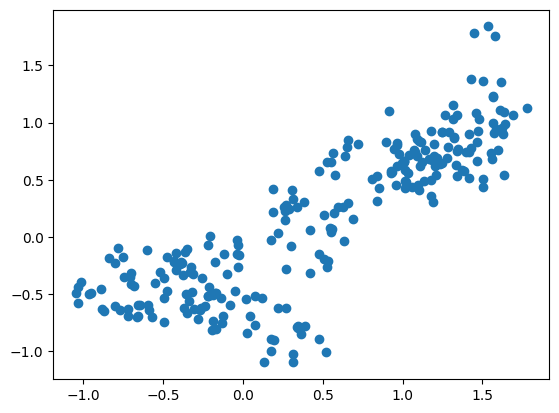

In [70]:
print(loaded_samples.keys())
w1_name, w2_name = 'layers.1.weight', 'layers.1.weight'

# for i in range(10):
#     w1 = loaded_samples[w1_name][:,i,1]
#     w2 = loaded_samples[w2_name][:,i,2]

#     plt.scatter(w1, w2)
#     plt.show()

w1 = loaded_samples[w1_name][:,2,8]
w2 = loaded_samples[w2_name][:,2,9]

plt.scatter(w1, w2)
plt.show()

# plt.hist(w1, bins=15)
# plt.show()
# plt.hist(w2, bins=15)
# plt.show()

In [68]:
import torch
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from itertools import product

def find_best_r2_pair(tensor):
    """
    Finds the pair of (x, y) indices with the highest R^2 coefficient.
    
    Parameters:
    tensor (torch.Tensor): A tensor of shape [250, n1, n2] containing the data.
    
    Returns:
    tuple: The best ((x_i, x_j), (y_i, y_j)) pair with the highest R^2 value and the corresponding R^2 score.
    """
    num_samples, n1, n2 = tensor.shape
    best_pair = None
    best_r2 = float('-inf')
    
    for (x_i, x_j), (y_i, y_j) in product(product(range(n1), range(n2)), repeat=2):
        if (x_i, x_j) == (y_i, y_j):
            continue
        
        x = tensor[:, x_i, x_j].numpy().reshape(-1, 1)  # Convert to NumPy and reshape for sklearn
        y = tensor[:, y_i, y_j].numpy()
        
        model = LinearRegression()
        model.fit(x, y)
        y_pred = model.predict(x)
        r2 = r2_score(y, y_pred)
        
        if r2 > best_r2:
            best_r2 = r2
            best_pair = ((x_i, x_j), (y_i, y_j))
    
    return best_pair, best_r2

# Example usage
tensor = loaded_samples['layers.1.weight']  # Example tensor with random values
best_pair, best_r2 = find_best_r2_pair(tensor)
print(f"Best dataset pair: {best_pair} with R^2 = {best_r2:.4f}")


Best dataset pair: ((2, 8), (2, 9)) with R^2 = 0.7032
